In [ ]:
import os
from pathlib import Path

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import HybridizationType
from rdkit.Chem.rdchem import BondType as BT

import pandas as pd
import numpy as np


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import dgl
import dgl.function as fn
from dgl.data import DGLDataset
from dgl.data import QM9EdgeDataset
import dgl.nn as dglnn
from dgl.dataloading import GraphDataLoader

import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import pickle

# This notebook requires torch >= 2.0
torch.__version__

'2.2.2'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
DATA_PATH = os.path.join(os.getcwd(),"data")
MODEL_FOLDER = os.path.join(os.getcwd(),"models")
TRAIN_FILE = os.path.join(DATA_PATH, "train.csv")
TEST_FILE = os.path.join(DATA_PATH, "test.csv")
STRUCTURES_FOLDER = os.path.join(DATA_PATH, "structures")
STRUCTURES_FILE = os.path.join(DATA_PATH, "structures.csv")
structures_data = pd.read_csv(STRUCTURES_FILE)
train = pd.read_csv(TRAIN_FILE, index_col=0)
test = pd.read_csv(TEST_FILE, index_col=0)

In [ ]:
coordinate_scaler = MinMaxScaler(feature_range=(-1, 1))
coupling_scaler = MinMaxScaler(feature_range=(-1, 1))
#structures_data[['x', 'y', 'z']] = coordinate_scaler.fit_transform(structures_data[['x', 'y', 'z']])
#train[['scalar_coupling_constant']] = coupling_scaler.fit_transform(train[['scalar_coupling_constant']])

In [ ]:
train.head()

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [ ]:
### Structure data contains coordinates but doesen't have information of which atoms are bonded
### In order to build this feature, and being able to work with graphs, let's try to establish which atoms are bonded
### As coordinates are in cartesian coordinates, atom-pair distance can be calculated from the coordinates

def atomic_distance(atom_1, atom_2):
    """
    Returns the euclidean distance between the coordinates of two atoms.
    Inputs:
        atom_1: Array containing the Cartesian coordinates of the first atom.
        atom_2: Array containing the Cartesian coordinates of the second atom.
    Outputs:
        distance: Euclidean distance between the atoms.
    """
    distance = np.linalg.norm(atom_1 - atom_2)
    return distance

In [ ]:
def get_distance_matrix(molecule):
    """
    Given the DataFrame containing data from a molecule in Structures.csv
    computes the distance matrix between each atom pair of the molecule.
    Inputs:
        molecule: DataFrame containing the information of a molecule
    Outputs:
        distance_matrix: Numpy array representing the matrix of the distance of each pair of atoms
    """
    num_atoms = molecule.shape[0]
    distance_matrix = np.zeros((num_atoms, num_atoms), dtype=np.float32)

    coordinates = molecule[["x", "y", "z"]].values

    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):
            distance_matrix[i][j] = atomic_distance(coordinates[i], coordinates[j])
            distance_matrix[j][i] = distance_matrix[i][j]

    return distance_matrix

In [ ]:
def get_adjacency_matrix(molecule, distance_matrix):
    """
    Returns the matrix of bonded pairs of atoms.
    """
    adjacency_matrix = np.zeros((distance_matrix.shape[0], distance_matrix.shape[1]))
    for row in range(distance_matrix.shape[0]):
        for col in range(row + 1, distance_matrix.shape[1]):
            # Get atom 1 name by index:
            r_atom_1 = molecule[molecule["atom_index"] == row]["covalent_radius"].values[0]
            r_atom_2 = molecule[molecule["atom_index"] == col]["covalent_radius"].values[0]
            covalent_distance = r_atom_1 + r_atom_2
            if distance_matrix[row][col] < covalent_distance:
                adjacency_matrix[row][col] = 1
                adjacency_matrix[col][row] = 1
    return adjacency_matrix

In [ ]:
def edge_list_from_adjacency_matrix(adjacency_matrix):
    src = []
    dst = []
    for i in range(adjacency_matrix.shape[0]):
        for j in range(i+1, adjacency_matrix.shape[1]):
            if adjacency_matrix[i][j] == 1:
                src.append(i)
                dst.append(j)
    return src, dst

In [ ]:
class SCCDataset(DGLDataset):
    def __init__(self, structures, couplings_data, type, force_reload=False):
        self.structures_data = structures
        self.couplings_data = couplings_data
        self.type = type
        self.graphs = None
        super(SCCDataset, self).__init__(name='SCCDataset')


    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]


    def process(self):
        self.graphs = self._generate_graphs()

    def _preprocess_data(self):
        ### Two atoms will be considered to be bonded if the distance between two atoms is less than the sum of their covalent radii
        ### This approach is obtained from the definitions and conventions of the XYZ file format for chemical structures:
        ### http://www.ccl.net/chemistry/resources/messages/1996/10/21.005-dir/index.html

        ### Covalent radii table
        ### https://en.wikipedia.org/wiki/Covalent_radius

        COVALENT_RADII = {"H": 0.35,
                         "C": 0.76,
                         "N": 0.71,
                         "O": 0.66,
                         "F": 0.57}

        # Add Covalent Radii to all structures
        self.structures_data['covalent_radius'] = self.structures_data['atom'].map(COVALENT_RADII)

        ### Let's keep featurizing the dataset. The next step will be to one-hot encode the atom column
        self.structures_data = pd.get_dummies(self.structures_data, columns=['atom'], drop_first=True, dtype='int')

    def _generate_graphs(self):
        # Adding features to the dataset:
        self._preprocess_data()

        graphs = []

        structures_grouped_by_mol = self.structures_data.groupby("molecule_name")
        couplings_grouped_by_mol = self.couplings_data.groupby("molecule_name")

        total_groups = len(couplings_grouped_by_mol)

        ### A partir de aquí hay que definir el bucle para generar los diferentes grafos.
        for idx, (mol_name, couplings) in enumerate(couplings_grouped_by_mol):
            if idx % 100 == 0:
                print(f'\rProgress {idx}/{total_groups} molecules processed', end="", flush=True)

            molecule_structure = structures_grouped_by_mol.get_group(mol_name)

            distance_matrix = self._get_distance_matrix(molecule_structure)
            adjacency_matrix = self._get_adjacency_matrix(molecule_structure, distance_matrix)

            # Adding self loops to the graph:
            adjacency_matrix = adjacency_matrix + np.eye(adjacency_matrix.shape[0])

            # Covalent bonds are considered symetric, thus we'll build an undirected graph.
            bidirected_adjacency_matrix = (adjacency_matrix + adjacency_matrix.T) / 2

            # Generate the lists of pairs of atoms (source, destination) that conform each bond in the molecule
            bond_src_atom, bond_dst_atom = self._edge_list_from_adjacency_matrix(adjacency_matrix)
            bond_src_atom = torch.tensor(bond_src_atom, dtype=torch.int64)
            bond_dst_atom = torch.tensor(bond_dst_atom, dtype=torch.int64)

            # Atomic coupling is also considered symmetric, thus we'll also build undirected interaction edges.
            couplings_src = torch.tensor(couplings['atom_index_0'].values, dtype=torch.int64)
            couplings_dst = torch.tensor(couplings['atom_index_1'].values, dtype=torch.int64)

            bidirected_couplings_src = torch.cat((couplings_src, couplings_dst))
            bidirected_couplings_dst = torch.cat((couplings_dst, couplings_src))

            ### Building the dictionary that will conform the heterograph, with one Node Type and two Edge Types
            data_dict = {('atom', 'bond', 'atom'): (bond_src_atom, bond_dst_atom),
                        ('atom', 'coupling', 'atom'): (bidirected_couplings_src, bidirected_couplings_dst)}

            g = dgl.heterograph(data_dict)

            node_features = molecule_structure.columns

            # Creating features for the nodes.
            # Hay que construir un tensor de n_nodos * n_características
            g.nodes['atom'].data['feats'] = torch.tensor(molecule_structure[molecule_structure.columns[2:]].values, dtype=torch.float32)

            # Creating features for the edges:
            # ('atom', 'coupling', 'atom') edges will contain the train scalar coupling constant
            scalar_coupling_constants = torch.tensor(couplings['scalar_coupling_constant'].values, dtype=torch.float32)
            bidirected_edge_scc = torch.cat((scalar_coupling_constants, scalar_coupling_constants), dim=0)
            g.edges['coupling'].data['label'] = bidirected_edge_scc

            graphs.append(g)

        print(f'\rAll molecules processed', end="", flush=True)
        return graphs

    def save(self):
        data_path = os.path.join(os.getcwd(),"data")
        graph_path = os.path.join(data_path, f"{self.type}.bin")
        dgl.save_graphs(graph_path, self.graphs)

    def load(self):
        data_path = os.path.join(os.getcwd(),"data")
        graph_path = os.path.join(data_path, f"{self.type}.bin")
        self.graphs, _ = dgl.load_graphs(graph_path)

    def has_cache(self):
        data_path = os.path.join(os.getcwd(),"data")
        graph_path = os.path.join(data_path, f"{self.type}.bin")
        return os.path.exists(graph_path)

    def _atomic_distance(self, atom_1, atom_2):
        ### Structure data contains coordinates but doesen't have information relating which atoms are bonded
        ### In order to build this feature, and being able to work with graphs, let's try to establish which atoms are bonded
        ### As coordinates are in cartesian coordinates, atom-pair distance can be calculated from the coordinates
        """
        Returns the euclidean distance between the coordinates of two atoms.
        Inputs:
            atom_1: Array containing the Cartesian coordinates of the first atom.
            atom_2: Array containing the Cartesian coordinates of the second atom.
        Outputs:
            distance: Euclidean distance between the atoms.
        """
        distance = np.linalg.norm(atom_1 - atom_2)
        return distance

    def _get_distance_matrix(self, molecule):
        """
        Given the DataFrame containing data from a molecule in Structures.csv
        computes the distance matrix between each atom pair of the molecule.
        Inputs:
            molecule: DataFrame containing the information of a molecule
        Outputs:
            distance_matrix: Numpy array representing the matrix of the distance of each pair of atoms
        """
        num_atoms = molecule.shape[0]
        distance_matrix = np.zeros((num_atoms, num_atoms), dtype=np.float32)

        coordinates = molecule[["x", "y", "z"]].values

        for i in range(num_atoms):
            for j in range(i + 1, num_atoms):
                distance_matrix[i][j] = atomic_distance(coordinates[i], coordinates[j])
                distance_matrix[j][i] = distance_matrix[i][j]

        return distance_matrix


    def _get_adjacency_matrix(self, molecule, distance_matrix):
        """
        Returns the matrix of bonded pairs of atoms.
        """
        adjacency_matrix = np.zeros((distance_matrix.shape[0], distance_matrix.shape[1]))
        for row in range(distance_matrix.shape[0]):
            for col in range(row + 1, distance_matrix.shape[1]):
                # Get atom 1 name by index:
                r_atom_1 = molecule[molecule["atom_index"] == row]["covalent_radius"].values[0]
                r_atom_2 = molecule[molecule["atom_index"] == col]["covalent_radius"].values[0]
                covalent_distance = r_atom_1 + r_atom_2
                if distance_matrix[row][col] < covalent_distance:
                    adjacency_matrix[row][col] = 1
                    adjacency_matrix[col][row] = 1
        return adjacency_matrix


    def _edge_list_from_adjacency_matrix(self, adjacency_matrix):
        src = []
        dst = []
        for i in range(adjacency_matrix.shape[0]):
            for j in range(i+1, adjacency_matrix.shape[1]):
                if adjacency_matrix[i][j] == 1:
                    src.append(i)
                    dst.append(j)
        return src, dst

In [ ]:
###Test Heterogeneous graph conv for regression
class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()
        self.conv1 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(in_feats, hid_feats)
            for rel in rel_names}, aggregate='sum')
        self.conv2 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = {k: F.relu(v) for k,v in h.items()}
        h = self.conv2(graph, h)
        return h

In [ ]:
## This classs is for Link prediction
class HeteroDotProductPredictor(nn.Module):
    def forward(self, graph, h, etype):
        # h contains the node representations for each edge type computed from
        # the GNN for heterogeneous graphs defined in the node classification
        with graph.local_scope():
            # assigns 'h' of all nodes in one shot
            # Si solo hay un tipo de nodo en el grafo, hay que incluir sobre qué tipo aplica:
            #https://discuss.dgl.ai/t/assertionerror-the-heteronodedataview-has-only-one-node-type-please-pass-a-tensor-directly/2140
            graph.ndata['h'] = h['atom']
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'), etype=etype)
            return graph.edges[etype].data['score']

In [ ]:
## This classs is for Link prediction
class HeteroMLPPredictor(nn.Module):
    def __init__(self, in_features, hidden_features, out_classes=1, num_hidden_layers=5):
        super().__init__()
        self.input_layer = nn.Linear(in_features*2, hidden_features)

        # hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_features, hidden_features))

        self.output_layer = nn.Linear(hidden_features, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']

        h_cat = torch.cat([h_u, h_v], dim=1)
        h = self.input_layer(h_cat)
        h = F.relu(h)

        for hidden_layer in self.hidden_layers:
            h = hidden_layer(h)
            h = F.relu(h)

        score = self.output_layer(h)
        return {'score': score}

    def forward(self, graph, h, etype):
        with graph.local_scope():
            graph.ndata['h'] = h['atom']
            graph.apply_edges(self.apply_edges, etype=etype)
            return graph.edges[etype].data['score']


In [ ]:
class GCN1(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        # Define the RGCN layer without specifying relationship names
        self.sage = RGCN(in_features, hidden_features, out_features, rel_names)
        # Define the predictor
        self.pred = HeteroDotProductPredictor()

    def forward(self, g, x, etype):
        # Pass the input graph and node features through the RGCN layer
        h = self.sage(g, x)
        # Pass the output of the RGCN layer and the edge type to the predictor
        return self.pred(g, h, etype)

In [ ]:
# Creating the train and validation datasets:
train_val_data = SCCDataset(structures=structures_data, couplings_data=train, type="train")
train_data, val_data = train_test_split(train_val_data, test_size=0.05)

# In order to process the Test dataset, we need to initialize the scalar_coupling_constant to 0.
test['scalar_coupling_constant'] = 0
test_data = SCCDataset(structures=structures_data, couplings_data=test, type="test")

In [ ]:
train_loader = GraphDataLoader(train_data, batch_size=5, shuffle=True, drop_last=False)
val_loader = GraphDataLoader(val_data, batch_size=5, drop_last=False)
test_loader = GraphDataLoader(test_data, batch_size=5, drop_last=False)

# PRIMER MODELO

In [ ]:
class HeteroEdgeRegressionGNN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_layers, rel_names):
        super(HeteroEdgeRegressionGNN, self).__init__()

        # Lista de capas de convolución de grafos
        self.layers = nn.ModuleList()

        # Primera capa
        self.layers.append(dgl.nn.HeteroGraphConv(
            {rel: dgl.nn.GraphConv(in_feats, hidden_size)
             for rel in rel_names}, aggregate='sum'))

        # Capas ocultas
        for _ in range(num_layers - 1):
            self.layers.append(dgl.nn.HeteroGraphConv(
                {rel: dgl.nn.GraphConv(hidden_size, hidden_size)
                 for rel in rel_names}, aggregate='sum'))

        # MLP para predecir los valores de las aristas para cada tipo de relación
        self.edge_mlp = nn.ModuleDict(
            {rel: nn.Linear(2 * hidden_size, 1)  # Concatenamos las características de los nodos de origen y destino
             for rel in rel_names})

    def forward(self, g, inputs):
        h = inputs

        # Aplicamos las capas de convolución de grafos
        for layer in self.layers:
            h = layer(g, {'atom': h})['atom']  # Usamos 'atom' como el nombre del nodo
            h = F.relu(h)

        predictions = {}

        # Usamos el contexto local del grafo
        with g.local_scope():
            g.ndata['h'] = h  # Asignamos las características de los nodos actualizadas

            # Para cada tipo de arista, realizamos la predicción
            for etype in g.etypes:  # Iteramos sobre todos los tipos de aristas
                g.apply_edges(lambda edges: {'score': self.edge_mlp[etype](torch.cat([edges.src['h'], edges.dst['h']], dim=1))}, etype=etype)
                predictions[etype] = g.edges[etype].data['score']

        return predictions

Epoch 0: Progress 16152/16153 batches processed
Epoch 0, Training Loss: 1173.746368561235, Validation Loss: 1138.7820943794295
Epoch 1: Progress 16152/16153 batches processed
Epoch 1, Training Loss: 1112.8152786847172, Validation Loss: 1100.5029033656406
Epoch 2: Progress 16152/16153 batches processed
Epoch 2, Training Loss: 1084.8987895979983, Validation Loss: 1080.0318307305054
Epoch 3: Progress 16152/16153 batches processed
Epoch 3, Training Loss: 1072.4569789848924, Validation Loss: 1073.2066153359328
Epoch 4: Progress 16152/16153 batches processed
Epoch 4, Training Loss: 1066.7270423474936, Validation Loss: 1070.1722598585764
Epoch 5: Progress 16152/16153 batches processed
Epoch 5, Training Loss: 1064.4559180508204, Validation Loss: 1067.492879040513
Epoch 6: Progress 16152/16153 batches processed
Epoch 6, Training Loss: 1063.3542880958828, Validation Loss: 1066.6304556536197
Epoch 7: Progress 16152/16153 batches processed
Epoch 7, Training Loss: 1062.4800185906897, Validation Los

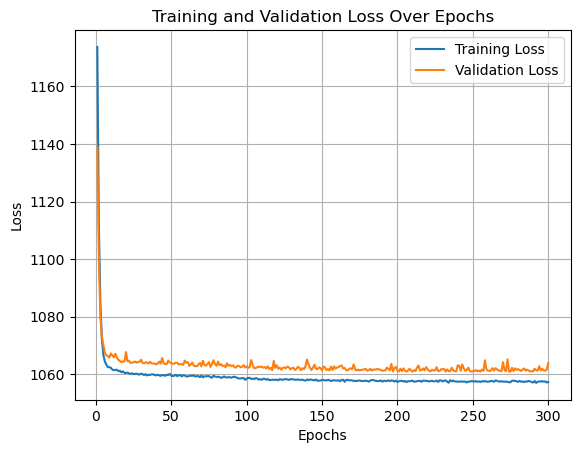

In [ ]:
NUM_EPOCHS = 300
IN_FEATURES = 8
HIDDEN_FEATURES = IN_FEATURES * 2
REL_NAMES = train_data[0].etypes

model = GCN1(in_features=IN_FEATURES, hidden_features=HIDDEN_FEATURES, out_features=1, rel_names=REL_NAMES)

if torch.cuda.is_available():
    model.to(device)

opt = torch.optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    total_train_loss = 0

    model.train()

    for idx, batch_graphs in enumerate(train_loader):
        batch_graphs = batch_graphs.to(device)
        node_feats = {'atom': batch_graphs.nodes['atom'].data['feats'].to(device)}
        labels = batch_graphs.edges['coupling'].data['label'].to(device)

        # Forward pass
        preds = model(batch_graphs, node_feats, 'coupling')
        preds = preds.squeeze()


        # Compute loss
        loss = loss_fn(preds, labels)

        # Backward pass and optimization
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_train_loss += loss.item()

        print(f'\rEpoch {epoch}: Progress {idx}/{len(train_loader)} batches processed', end="", flush=True)

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # print(f'\nEpoch {epoch}, Loss: {total_loss / len(train_data)}')

    # Validation step
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch_graphs in val_loader:
            batch_graphs = batch_graphs.to(device)
            node_feats = {'atom': batch_graphs.nodes['atom'].data['feats'].to(device)}
            labels = batch_graphs.edges['coupling'].data['label'].to(device)

            # Forward pass
            preds = model(batch_graphs, node_feats, 'coupling')
            preds = preds.squeeze()

            # Compute val loss
            loss = loss_fn(preds, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'\nEpoch {epoch}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

    if (epoch + 1) % 10 == 0:
        model_save_path = os.path.join(MODEL_FOLDER, f'RGCNEdgeRegression_epoch_{epoch + 1}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved to {model_save_path}')

plt.figure()
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1,NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

In [ ]:
print(model)

GCN1(
  (sage): RGCN(
    (conv1): HeteroGraphConv(
      (mods): ModuleDict(
        (bond): GraphConv(in=8, out=16, normalization=both, activation=None)
        (coupling): GraphConv(in=8, out=16, normalization=both, activation=None)
      )
    )
    (conv2): HeteroGraphConv(
      (mods): ModuleDict(
        (bond): GraphConv(in=16, out=1, normalization=both, activation=None)
        (coupling): GraphConv(in=16, out=1, normalization=both, activation=None)
      )
    )
  )
  (pred): HeteroDotProductPredictor()
)


In [ ]:
### Loading the trained model:
NUM_EPOCHS = 300
IN_FEATURES = 8
HIDDEN_FEATURES = IN_FEATURES * 2
REL_NAMES = train_data[0].etypes

model = GCN1(in_features=IN_FEATURES, hidden_features=HIDDEN_FEATURES, out_features=1, rel_names=REL_NAMES)
model.load_state_dict(torch.load(os.path.join(MODEL_FOLDER, f'RGCNEdgeRegression_epoch_{NUM_EPOCHS}.pth')))

<All keys matched successfully>

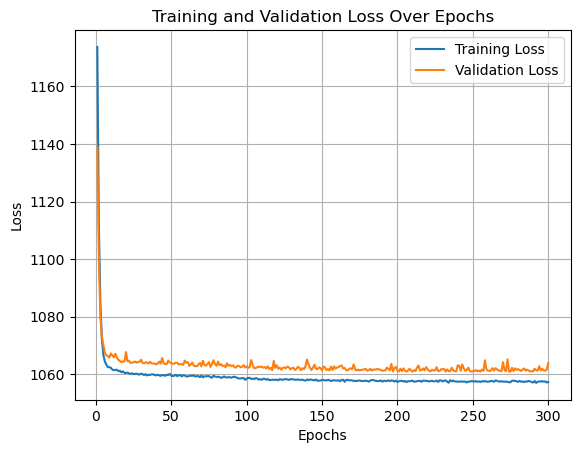

In [ ]:
plt.figure()
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1,NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

# SEGUNDO MODELO

In [ ]:
class MultiLayerRGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names, num_layers=2):
        super().__init__()
        self.convs = nn.ModuleList([
            dglnn.HeteroGraphConv({
                rel: dglnn.GraphConv(in_feats if i == 0 else hid_feats, hid_feats)
                for rel in rel_names}, aggregate='sum')
            for i in range(num_layers - 1)
        ])
        self.convn = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = inputs
        for conv in self.convs:
            h = conv(graph, h)
            h = {k: F.relu(v) for k,v in h.items()}
        h = self.convn(graph, h)
        return h

In [ ]:
class GCN2(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names, num_layers):
        super().__init__()
        # Define the RGCN layer without specifying relationship names
        self.sage = MultiLayerRGCN(in_features, hidden_features, out_features, rel_names, num_layers)
        # Define the predictor
        self.pred = HeteroMLPPredictor(in_features=out_features,
                                       hidden_features=hidden_features,
                                       num_hidden_layers=5,
                                       out_classes=1)

    def forward(self, g, x, etype):
        # Pass the input graph and node features through the RGCN layer
        h = self.sage(g, x)
        # Pass the output of the RGCN layer and the edge type to the predictor
        return self.pred(g, h, etype)

In [ ]:
NUM_EPOCHS = 150
IN_FEATURES = 8
HIDDEN_FEATURES = IN_FEATURES * 8 * 8
REL_NAMES = train_data[0].etypes

model = GCN2(in_features=IN_FEATURES, hidden_features=HIDDEN_FEATURES, out_features=1, rel_names=REL_NAMES, num_layers=5)

if torch.cuda.is_available():
    model.to(device)

opt = torch.optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

Epoch 0: Progress 16153/16153 batches processed
Epoch 0, Training Loss: 724.3270537466676, Validation Loss: 614.8975728233329
Epoch 1: Progress 16153/16153 batches processed
Epoch 1, Training Loss: 603.5258916815774, Validation Loss: 580.9383565362556
Epoch 2: Progress 16153/16153 batches processed
Epoch 2, Training Loss: 636.9943743962987, Validation Loss: 595.2211626637836
Epoch 3: Progress 16153/16153 batches processed
Epoch 3, Training Loss: 590.3550749593185, Validation Loss: 551.6003933647685
Epoch 4: Progress 16153/16153 batches processed
Epoch 4, Training Loss: 558.3022937915174, Validation Loss: 542.9891752249766
Epoch 5: Progress 16153/16153 batches processed
Epoch 5, Training Loss: 540.8704012855025, Validation Loss: 538.8006600224173
Epoch 6: Progress 16153/16153 batches processed
Epoch 6, Training Loss: 526.3140528890317, Validation Loss: 523.9525222867973
Epoch 7: Progress 16153/16153 batches processed
Epoch 7, Training Loss: 516.9007753868011, Validation Loss: 512.986619

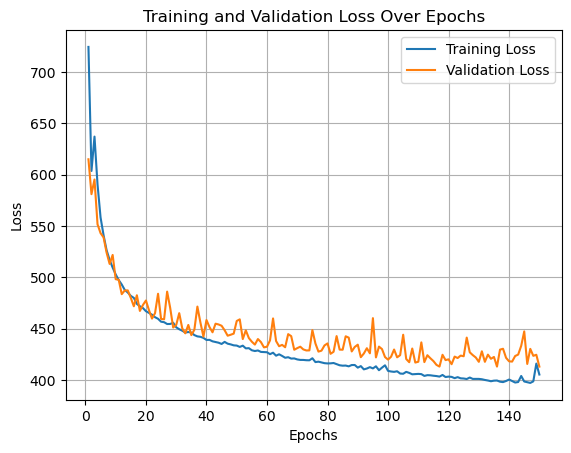

In [ ]:
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    total_train_loss = 0

    model.train()

    for idx, batch_graphs in enumerate(train_loader):
        batch_graphs = batch_graphs.to(device)
        node_feats = {'atom': batch_graphs.nodes['atom'].data['feats'].to(device)}
        labels = batch_graphs.edges['coupling'].data['label'].to(device)

        # Forward pass
        preds = model(batch_graphs, node_feats, 'coupling')
        preds = preds.squeeze()

        # Compute loss
        loss = loss_fn(preds, labels)

        # Backward pass and optimization
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_train_loss += loss.item()

        print(f'\rEpoch {epoch}: Progress {idx+1}/{len(train_loader)} batches processed', end="", flush=True)

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # print(f'\nEpoch {epoch}, Loss: {total_loss / len(train_data)}')

    # Validation step
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch_graphs in val_loader:
            batch_graphs = batch_graphs.to(device)
            node_feats = {'atom': batch_graphs.nodes['atom'].data['feats'].to(device)}
            labels = batch_graphs.edges['coupling'].data['label'].to(device)

            # Forward pass
            preds = model(batch_graphs, node_feats, 'coupling')
            preds = preds.squeeze()

            # Compute val loss
            loss = loss_fn(preds, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'\nEpoch {epoch}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

    if (epoch + 1) % 10 == 0:
        model_save_path = os.path.join(MODEL_FOLDER, f'Multilayer_{epoch + 1}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved to {model_save_path}')

plt.figure()
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1,NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

In [ ]:
print(GCN2)

<class '__main__.GCN2'>


In [ ]:
NUM_EPOCHS = 50
IN_FEATURES = 8
HIDDEN_FEATURES = IN_FEATURES * 8
REL_NAMES = train_data[0].etypes

model = GCN2(in_features=IN_FEATURES, hidden_features=HIDDEN_FEATURES, out_features=1, rel_names=REL_NAMES, num_layers=5)

if torch.cuda.is_available():
    model.to(device)

opt = torch.optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

Epoch 0: Progress 16153/16153 batches processed
Epoch 0, Training Loss: 782.4870934487275, Validation Loss: 801.2637177051585
Epoch 1: Progress 16153/16153 batches processed
Epoch 1, Training Loss: 673.4923670385036, Validation Loss: 642.8556507437826
Epoch 2: Progress 16153/16153 batches processed
Epoch 2, Training Loss: 647.4281631986445, Validation Loss: 626.44356632793
Epoch 3: Progress 16153/16153 batches processed
Epoch 3, Training Loss: 627.7600217606788, Validation Loss: 597.2869309135106
Epoch 4: Progress 16153/16153 batches processed
Epoch 4, Training Loss: 604.8820828430897, Validation Loss: 601.0520545430526
Epoch 5: Progress 16153/16153 batches processed
Epoch 5, Training Loss: 593.0518125100585, Validation Loss: 606.7673667970471
Epoch 6: Progress 16153/16153 batches processed
Epoch 6, Training Loss: 583.0774889882043, Validation Loss: 612.963181940565
Epoch 7: Progress 16153/16153 batches processed
Epoch 7, Training Loss: 579.1523072093897, Validation Loss: 565.396323126

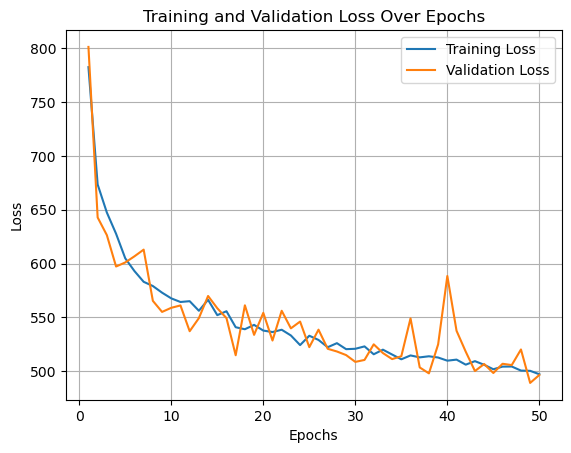

In [ ]:
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    total_train_loss = 0

    model.train()

    for idx, batch_graphs in enumerate(train_loader):
        batch_graphs = batch_graphs.to(device)
        node_feats = {'atom': batch_graphs.nodes['atom'].data['feats'].to(device)}
        labels = batch_graphs.edges['coupling'].data['label'].to(device)

        # Forward pass
        preds = model(batch_graphs, node_feats, 'coupling')
        preds = preds.squeeze()

        # Compute loss
        loss = loss_fn(preds, labels)

        # Backward pass and optimization
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_train_loss += loss.item()

        print(f'\rEpoch {epoch}: Progress {idx+1}/{len(train_loader)} batches processed', end="", flush=True)

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # print(f'\nEpoch {epoch}, Loss: {total_loss / len(train_data)}')

    # Validation step
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch_graphs in val_loader:
            batch_graphs = batch_graphs.to(device)
            node_feats = {'atom': batch_graphs.nodes['atom'].data['feats'].to(device)}
            labels = batch_graphs.edges['coupling'].data['label'].to(device)

            # Forward pass
            preds = model(batch_graphs, node_feats, 'coupling')
            preds = preds.squeeze()

            # Compute val loss
            loss = loss_fn(preds, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'\nEpoch {epoch}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

    if (epoch + 1) % 10 == 0:
        model_save_path = os.path.join(MODEL_FOLDER, f'Multilayer2_{epoch + 1}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved to {model_save_path}')

plt.figure()
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1,NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

In [ ]:
NUM_EPOCHS = 50
IN_FEATURES = 8
HIDDEN_FEATURES = IN_FEATURES * 8
REL_NAMES = train_data[0].etypes

model = GCN2(in_features=IN_FEATURES, hidden_features=HIDDEN_FEATURES, out_features=8, rel_names=REL_NAMES, num_layers=5)

if torch.cuda.is_available():
    model.to(device)

opt = torch.optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

Epoch 0: Progress 16153/16153 batches processed
Epoch 0, Training Loss: 380.2017694715449, Validation Loss: 302.338377929042
Epoch 1: Progress 16153/16153 batches processed
Epoch 1, Training Loss: 274.4093018017383, Validation Loss: 270.4590639502125
Epoch 2: Progress 16153/16153 batches processed
Epoch 2, Training Loss: 250.0135368563727, Validation Loss: 258.8177029467357
Epoch 3: Progress 16153/16153 batches processed
Epoch 3, Training Loss: 238.26406200873936, Validation Loss: 224.48129439886253
Epoch 4: Progress 16153/16153 batches processed
Epoch 4, Training Loss: 230.95609835507383, Validation Loss: 215.7774129210852
Epoch 5: Progress 16153/16153 batches processed
Epoch 5, Training Loss: 225.51284763890214, Validation Loss: 224.1304861286132
Epoch 6: Progress 16153/16153 batches processed
Epoch 6, Training Loss: 221.5462205222404, Validation Loss: 219.00510630400285
Epoch 7: Progress 16153/16153 batches processed
Epoch 7, Training Loss: 218.32776798089355, Validation Loss: 218.3

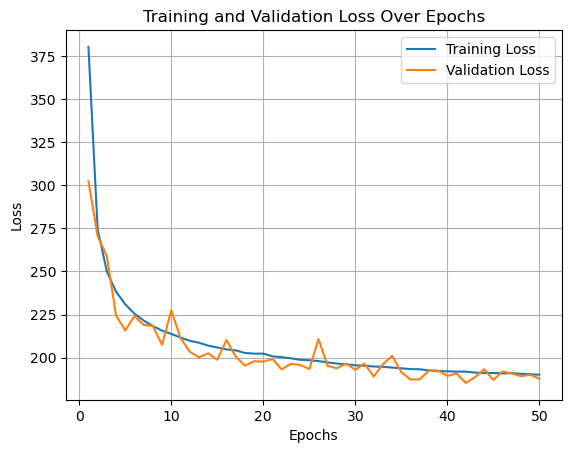

In [ ]:
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    total_train_loss = 0

    model.train()

    for idx, batch_graphs in enumerate(train_loader):
        batch_graphs = batch_graphs.to(device)
        node_feats = {'atom': batch_graphs.nodes['atom'].data['feats'].to(device)}
        labels = batch_graphs.edges['coupling'].data['label'].to(device)

        # Forward pass
        preds = model(batch_graphs, node_feats, 'coupling')
        preds = preds.squeeze()

        # Compute loss
        loss = loss_fn(preds, labels)

        # Backward pass and optimization
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_train_loss += loss.item()

        print(f'\rEpoch {epoch}: Progress {idx+1}/{len(train_loader)} batches processed', end="", flush=True)

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # print(f'\nEpoch {epoch}, Loss: {total_loss / len(train_data)}')

    # Validation step
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch_graphs in val_loader:
            batch_graphs = batch_graphs.to(device)
            node_feats = {'atom': batch_graphs.nodes['atom'].data['feats'].to(device)}
            labels = batch_graphs.edges['coupling'].data['label'].to(device)

            # Forward pass
            preds = model(batch_graphs, node_feats, 'coupling')
            preds = preds.squeeze()

            # Compute val loss
            loss = loss_fn(preds, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'\nEpoch {epoch}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

    if (epoch + 1) % 10 == 0:
        model_save_path = os.path.join(MODEL_FOLDER, f'Multilayer3_{epoch + 1}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved to {model_save_path}')

plt.figure()
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1,NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

### Evaluación de los modelos (MAE)

Validation MAE: 23.154581486828597


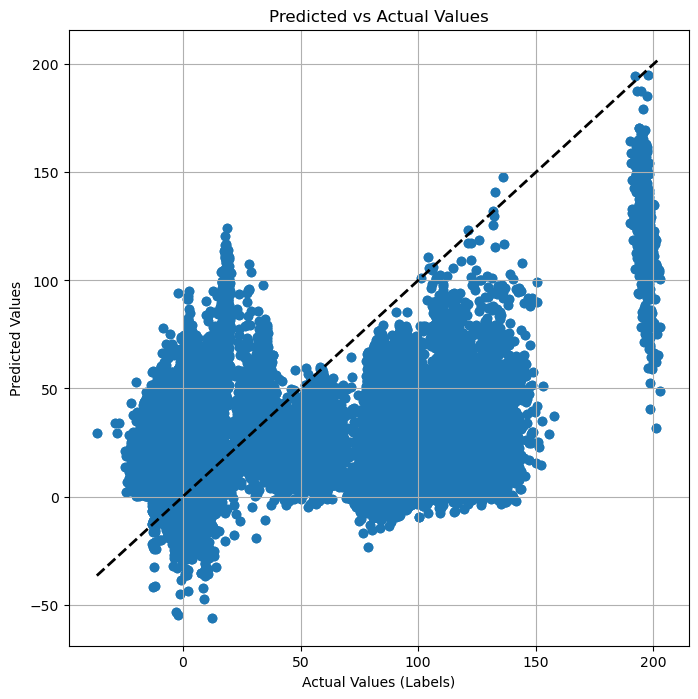

In [ ]:
from torchmetrics.functional import mean_absolute_error

NUM_EPOCHS = 300
IN_FEATURES = 8
HIDDEN_FEATURES = IN_FEATURES * 2
REL_NAMES = train_data[0].etypes

model0 = GCN1(in_features=IN_FEATURES, hidden_features=HIDDEN_FEATURES, out_features=1, rel_names=REL_NAMES)

if torch.cuda.is_available():
    model0.to(device)

model0_save_path = os.path.join(MODEL_FOLDER, f'RGCNEdgeRegression_epoch_300.pth')
model0.load_state_dict(torch.load((model0_save_path)))

model0.eval()

total_val_mae = 0
val_maes = []
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_graphs in val_loader:
        batch_graphs = batch_graphs.to(device)
        node_feats = {'atom': batch_graphs.nodes['atom'].data['feats'].to(device)}
        labels = batch_graphs.edges['coupling'].data['label'].to(device)

        preds = model0(batch_graphs, node_feats, 'coupling')
        preds = preds.squeeze()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        batch_mae = mean_absolute_error(preds, labels)
        total_val_mae += batch_mae.item()

avg_val_mae = total_val_mae / len(val_loader)
val_maes.append(avg_val_mae)

print(f"Validation MAE: {avg_val_mae}")

plt.figure(figsize=(8, 8))
plt.scatter(all_labels, all_preds)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'k--', linewidth=2)
plt.xlabel("Actual Values (Labels)")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.grid(True)
plt.show()

Validation MAE: 10.501735362827288


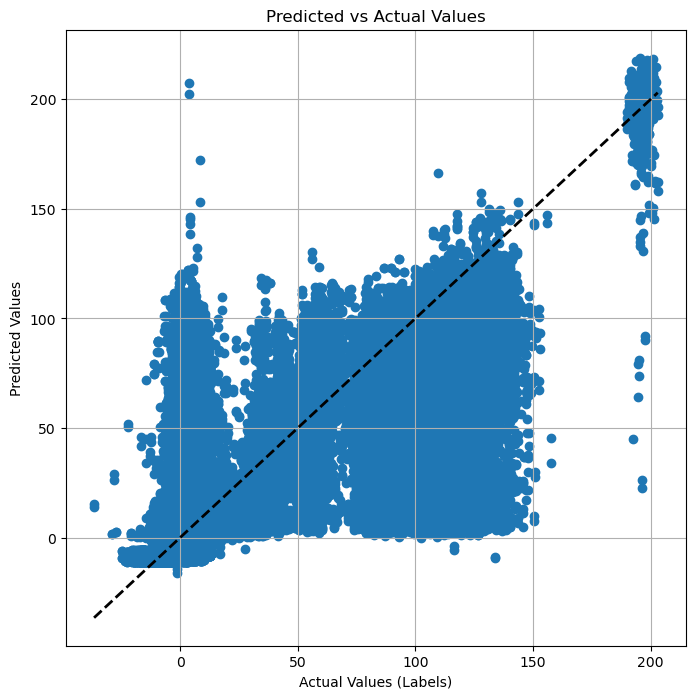

In [ ]:
NUM_EPOCHS = 150
IN_FEATURES = 8
HIDDEN_FEATURES = IN_FEATURES * 8 * 8
REL_NAMES = train_data[0].etypes

model1 = GCN2(in_features=IN_FEATURES, hidden_features=HIDDEN_FEATURES, out_features=1, rel_names=REL_NAMES, num_layers=5)

if torch.cuda.is_available():
    model1.to(device)

model1_save_path = os.path.join(MODEL_FOLDER, f'Multilayer_150.pth')
model1.load_state_dict(torch.load((model1_save_path)))

model1.eval()

total_val_mae = 0
val_maes = []
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_graphs in val_loader:
        batch_graphs = batch_graphs.to(device)
        node_feats = {'atom': batch_graphs.nodes['atom'].data['feats'].to(device)}
        labels = batch_graphs.edges['coupling'].data['label'].to(device)

        preds = model1(batch_graphs, node_feats, 'coupling')
        preds = preds.squeeze()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        batch_mae = mean_absolute_error(preds, labels)
        total_val_mae += batch_mae.item()

avg_val_mae = total_val_mae / len(val_loader)
val_maes.append(avg_val_mae)

print(f"Validation MAE: {avg_val_mae}")

plt.figure(figsize=(8, 8))
plt.scatter(all_labels, all_preds)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'k--', linewidth=2)
plt.xlabel("Actual Values (Labels)")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.grid(True)
plt.show()

Validation MAE: 12.053542246409505


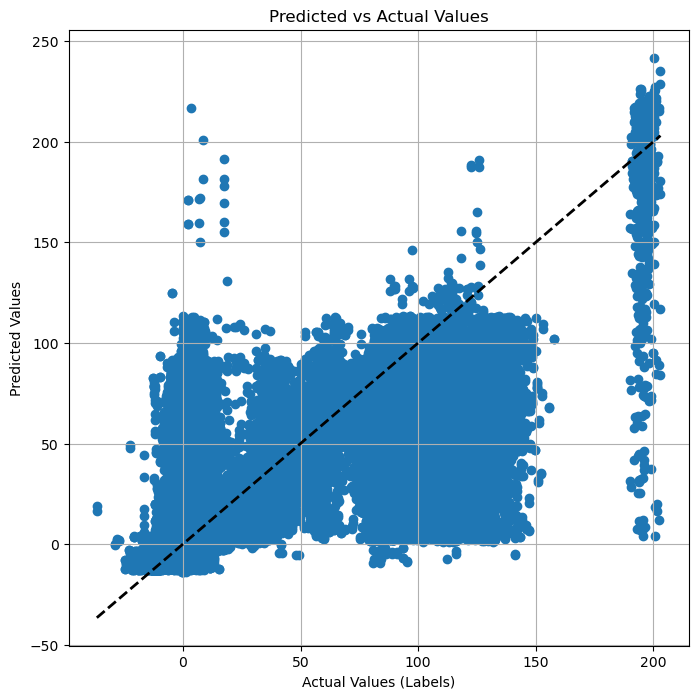

In [ ]:
NUM_EPOCHS = 50
IN_FEATURES = 8
HIDDEN_FEATURES = IN_FEATURES * 8
REL_NAMES = train_data[0].etypes

model2 = GCN2(in_features=IN_FEATURES, hidden_features=HIDDEN_FEATURES, out_features=1, rel_names=REL_NAMES, num_layers=5)

if torch.cuda.is_available():
    model2.to(device)

model2_save_path = os.path.join(MODEL_FOLDER, f'Multilayer2_50.pth')
model2.load_state_dict(torch.load((model2_save_path)))

model2.eval()

total_val_mae = 0
val_maes = []
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_graphs in val_loader:
        batch_graphs = batch_graphs.to(device)
        node_feats = {'atom': batch_graphs.nodes['atom'].data['feats'].to(device)}
        labels = batch_graphs.edges['coupling'].data['label'].to(device)

        preds = model2(batch_graphs, node_feats, 'coupling')
        preds = preds.squeeze()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        batch_mae = mean_absolute_error(preds, labels)
        total_val_mae += batch_mae.item()

avg_val_mae = total_val_mae / len(val_loader)
val_maes.append(avg_val_mae)

print(f"Validation MAE: {avg_val_mae}")

plt.figure(figsize=(8, 8))
plt.scatter(all_labels, all_preds)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'k--', linewidth=2)
plt.xlabel("Actual Values (Labels)")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.grid(True)
plt.show()

Validation MAE: 6.444121101908342


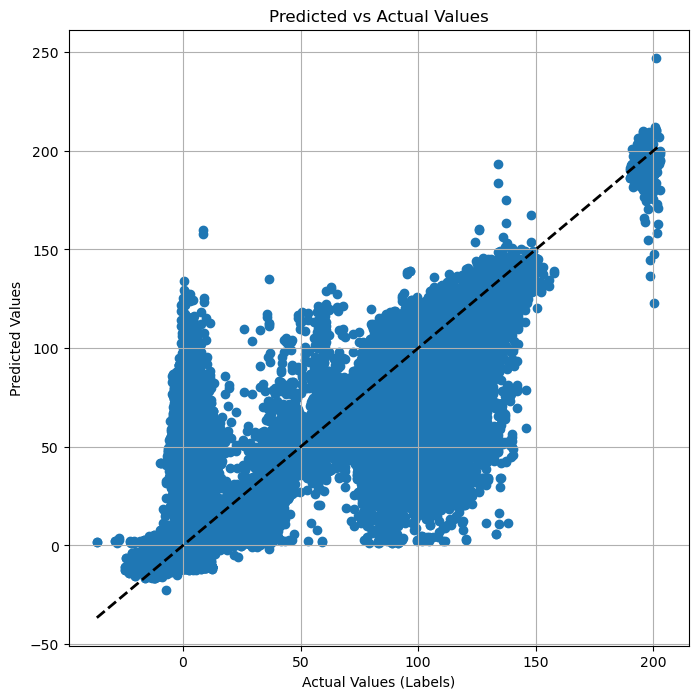

In [ ]:
NUM_EPOCHS = 50
IN_FEATURES = 8
HIDDEN_FEATURES = IN_FEATURES * 8
REL_NAMES = train_data[0].etypes

model3 = GCN2(in_features=IN_FEATURES, hidden_features=HIDDEN_FEATURES, out_features=8, rel_names=REL_NAMES, num_layers=5)

if torch.cuda.is_available():
    model3.to(device)

model3_save_path = os.path.join(MODEL_FOLDER, f'Multilayer3_50.pth')
model3.load_state_dict(torch.load((model3_save_path)))

model3.eval()

total_val_mae = 0
val_maes = []
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_graphs in val_loader:

        batch_graphs = batch_graphs.to(device)
        node_feats = {'atom': batch_graphs.nodes['atom'].data['feats'].to(device)}
        labels = batch_graphs.edges['coupling'].data['label'].to(device)


        preds = model3(batch_graphs, node_feats, 'coupling')
        preds = preds.squeeze()


        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


        batch_mae = mean_absolute_error(preds, labels)
        total_val_mae += batch_mae.item()

avg_val_mae = total_val_mae / len(val_loader)
val_maes.append(avg_val_mae)

print(f"Validation MAE: {avg_val_mae}")

plt.figure(figsize=(8, 8))
plt.scatter(all_labels, all_preds)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], 'k--', linewidth=2)
plt.xlabel("Actual Values (Labels)")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.grid(True)
plt.show()